In [122]:
import autograd.numpy as np
from autograd.scipy.stats import multivariate_normal, norm     # note this import
from autograd import grad, jacobian
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from tqdm.notebook import tqdm, trange
import torch

In [269]:
d_ = 2
l = 200

true_weights = np.array([-9, 15])

noise = 0.2

np.random.seed(12345)
d = np.random.rand(l)
ones = np.ones((d.shape[0], 1))
d = np.concatenate((np.reshape(d, (d.shape[0], 1)), ones), axis=1)
y = torch.tensor(np.random.normal(loc = 0, scale=np.sqrt(1.2), size=l) + true_weights[0] * d[:, 0] + true_weights[1]) # Linear function with slope 1 added noise epsilon
d = torch.tensor(d)
mean_prior = torch.tensor([0.0, 0.0])
A_prior = torch.tensor([[0.9, 0.3], [0.3, -3.0]])


In [274]:
def log_likelihood(y, theta, d):
    likelihood_cov = np.array([np.var(y)])
    likelihood_mean = np.array(theta.T @ d.T)
    #print("----")
    #print(y.T[0][0])
    #print(likelihood_cov)
    #print(stats.norm.pdf(y.T[0][0], loc=likelihood_mean[0], scale=likelihood_cov))
    return torch.tensor([
        multivariate_normal.logpdf(
            y.T[0][i], 
            mean=np.array(likelihood_mean[i]), 
            cov=likelihood_cov
        ) for i in range(len(y))])

def log_likelihood_torch(y, theta, d):
    likelihood_cov = torch.mean(torch.square(y - theta.T @ d.T)) * torch.eye(len(d))
    likelihood_mean = d @ theta
    #print("----")
    #print(y.T[0][0])
    #print(likelihood_cov)
    #print(stats.norm.pdf(y.T[0][0], loc=likelihood_mean[0], scale=likelihood_cov))
    return torch.distributions.MultivariateNormal(likelihood_mean, likelihood_cov).log_prob(y)
    #return torch.tensor([
    #    torch.distributions.MultivariateNormal(torch.tensor([likelihood_mean[i]]), likelihood_cov).log_prob(
    #        torch.as_tensor([y.T[0][i]])
    #    ) for i in range(len(y))], requires_grad=True)

def KLD(mean_q, A_q, mean_p, A_p):
    sigma_q = (A_q @ A_q.T).type(torch.float64)
    sigma_p = (A_p @ A_p.T).type(torch.float64)
    bar_sigma_q = torch.linalg.matrix_norm(sigma_q).type(torch.float64)
    bar_sigma_p = torch.linalg.matrix_norm(sigma_p).type(torch.float64)
    k = len(mean_q)
    return 0.5 * (torch.trace(torch.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ torch.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + torch.log(bar_sigma_p/bar_sigma_q))

def variational_inference(mean, A):
    shape = d.shape[1]
    samples = torch.distributions.MultivariateNormal(torch.zeros(shape), torch.eye(shape)).sample((shape*10,))
    values = []
    for sample in samples:
        theta = mean + A @ sample.type(torch.float64)
        values.append(log_likelihood_torch(y, theta, d))
    return torch.mean(torch.stack(values)) - KLD(mean, A, mean_prior, A_prior), torch.mean(torch.stack(values)), KLD(mean, A, mean_prior, A_prior)
    # Calculate ELBO to measure convergence
#likelihood(y, true_weights,d)
#variational_inference(np.ones(d.shape[1]), np.array([[4, 0.3], [0.1, -2.2]]))
#KLD(np.array([3, 3]), np.array([[3, 0],[0, 3]]), np.array([3, 3]), np.array([[3, 0],[0, 3]]))

  0%|          | 0/100 [00:00<?, ?it/s]

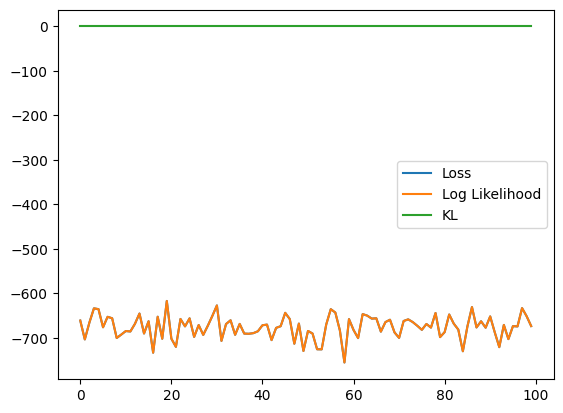

In [273]:
A_prior = torch.tensor([[3.2, 1.6], [1.1, 2.9]], requires_grad=True).type(torch.float64)
mean_prior = torch.tensor([2.3, 3.4], requires_grad=True).type(torch.float64)
parameters = [mean_prior.clone(), A_prior.clone()]
optimizer = torch.optim.SGD([mean_prior.detach(), A_prior.detach()], lr=0.001)
losses = []
logliks = []
kls = []
for i in trange(0, 100):
    optimizer.zero_grad()
    loss, loglik, kl = variational_inference(parameters[0], parameters[1])
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
    logliks.append(loglik.detach().numpy())
    kls.append(kl.detach().numpy())
plt.plot(np.arange(0, len(losses)), losses, label='Loss')
plt.plot(np.arange(0, len(losses)), logliks, label='Log Likelihood')
plt.plot(np.arange(0, len(losses)), kls, label="KL")
plt.legend()

# Old stuff, please ignore

/tmp/ipykernel_4412/901597217.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(x[0], requires_grad=True).type(torch.float64)
/tmp/ipykernel_4412/901597217.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(x[1:], requires_grad=True).type(torch.float64)
/tmp/ipykernel_4412/901597217.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gradient(torch.tensor(x0))


RuntimeError: One of the differentiated Tensors does not require grad

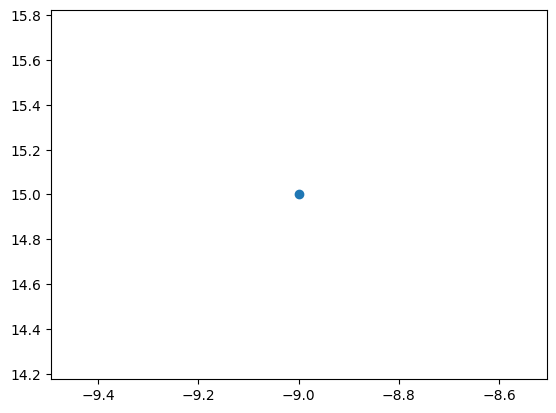

In [177]:
plt.scatter(true_weights[0], true_weights[1])
epoch = 0

def function_to_optimize(xp):
    x = xp.reshape(int(np.floor(len(xp)/2)), 2)
    mean = torch.tensor(x[0], requires_grad=True).type(torch.float64)
    A = torch.tensor(x[1:], requires_grad=True).type(torch.float64)
    return variational_inference(mean, A)

def gradient(x):
    new_x = x
    result = function_to_optimize(new_x)
    return torch.autograd.grad(result, new_x, allow_unused=True)
#gradient = grad(function_to_optimize)
#print(function_to_optimize(np.array([9.4, 14.4, 3, 0, 0.1, -2])))
#print(gradient(np.array([9.4, 14.4, 3, 0, 0.1, -2])))
x0 = torch.tensor([9.4, 14.4, 3.0, 0.0, 0.1, -2.0], requires_grad=True)
function_to_optimize(x0)
gradient(torch.tensor(x0))
x0.grad
#optimize.minimize(lambda x: function_to_optimize(x).detach().numpy(), 
#                  torch.tensor([9.4, 14.4, 3.0, 0.0, 0.1, -2.0], requires_grad=True), 
#                  method='BFGS', 
#                  options={'return_all': True}, 
#                  jac=gradient)

In [6]:
def f(x):
    return multivariate_normal.pdf(np.array([1,2]), mean=x, cov=np.array([[3, 2], [1, 2]]))
for i in range(100):
    for j in range(100):
        print(grad(f)(np.array([float(i), float(j)])))
#optimize.minimize(f, np.array([2, 3]), method='BFGS', options={'return_all': True}, jac=jacobian(f))

ValueError: setting an array element with a sequence.

In [22]:
def f(x):
    return torch.distributions.MultivariateNormal(x, torch.tensor([[4.0, 1.0],[1.0, 3.0]])).log_prob(torch.tensor([1.0,2.0]))
for i in range(100):
    for j in range(100):
        x = torch.tensor([i+0.0, j+0.0], requires_grad=True)
        y = f(x)
        gradients = torch.autograd.grad(y, x)
        #print(gradients)
        #print(x.grad)
        #print(grad(f)(np.array([float(i), float(j)])))

(tensor([0.0909, 0.6364]),)
None
(tensor([0.1818, 0.2727]),)
None
(tensor([ 0.2727, -0.0909]),)
None
(tensor([ 0.3636, -0.4545]),)
None
(tensor([ 0.4545, -0.8182]),)
None
(tensor([ 0.5455, -1.1818]),)
None
(tensor([ 0.6364, -1.5455]),)
None
(tensor([ 0.7273, -1.9091]),)
None
(tensor([ 0.8182, -2.2727]),)
None
(tensor([ 0.9091, -2.6364]),)
None
(tensor([ 1.0000, -3.0000]),)
None
(tensor([ 1.0909, -3.3636]),)
None
(tensor([ 1.1818, -3.7273]),)
None
(tensor([ 1.2727, -4.0909]),)
None
(tensor([ 1.3636, -4.4545]),)
None
(tensor([ 1.4545, -4.8182]),)
None
(tensor([ 1.5455, -5.1818]),)
None
(tensor([ 1.6364, -5.5455]),)
None
(tensor([ 1.7273, -5.9091]),)
None
(tensor([ 1.8182, -6.2727]),)
None
(tensor([ 1.9091, -6.6364]),)
None
(tensor([ 2., -7.]),)
None
(tensor([ 2.0909, -7.3636]),)
None
(tensor([ 2.1818, -7.7273]),)
None
(tensor([ 2.2727, -8.0909]),)
None
(tensor([ 2.3636, -8.4545]),)
None
(tensor([ 2.4545, -8.8182]),)
None
(tensor([ 2.5455, -9.1818]),)
None
(tensor([ 2.6364, -9.5455]),)
No

(tensor([  7., -31.]),)
None
(tensor([  7.0909, -31.3636]),)
None
(tensor([  7.1818, -31.7273]),)
None
(tensor([  7.2727, -32.0909]),)
None
(tensor([  7.3636, -32.4545]),)
None
(tensor([  7.4545, -32.8182]),)
None
(tensor([  7.5455, -33.1818]),)
None
(tensor([  7.6364, -33.5455]),)
None
(tensor([  7.7273, -33.9091]),)
None
(tensor([  7.8182, -34.2727]),)
None
(tensor([  7.9091, -34.6364]),)
None
(tensor([  8.0000, -35.0000]),)
None
(tensor([-1.2727,  1.0909]),)
None
(tensor([-1.1818,  0.7273]),)
None
(tensor([-1.0909,  0.3636]),)
None
(tensor([-1.,  0.]),)
None
(tensor([-0.9091, -0.3636]),)
None
(tensor([-0.8182, -0.7273]),)
None
(tensor([-0.7273, -1.0909]),)
None
(tensor([-0.6364, -1.4545]),)
None
(tensor([-0.5455, -1.8182]),)
None
(tensor([-0.4545, -2.1818]),)
None
(tensor([-0.3636, -2.5455]),)
None
(tensor([-0.2727, -2.9091]),)
None
(tensor([-0.1818, -3.2727]),)
None
(tensor([-0.0909, -3.6364]),)
None
(tensor([-5.9605e-08, -4.0000e+00]),)
None
(tensor([ 0.0909, -4.3636]),)
None
(ten

(tensor([  1.6364, -12.5455]),)
None
(tensor([  1.7273, -12.9091]),)
None
(tensor([  1.8182, -13.2727]),)
None
(tensor([  1.9091, -13.6364]),)
None
(tensor([  2., -14.]),)
None
(tensor([  2.0909, -14.3636]),)
None
(tensor([  2.1818, -14.7273]),)
None
(tensor([  2.2727, -15.0909]),)
None
(tensor([  2.3636, -15.4545]),)
None
(tensor([  2.4545, -15.8182]),)
None
(tensor([  2.5455, -16.1818]),)
None
(tensor([  2.6364, -16.5455]),)
None
(tensor([  2.7273, -16.9091]),)
None
(tensor([  2.8182, -17.2727]),)
None
(tensor([  2.9091, -17.6364]),)
None
(tensor([  3., -18.]),)
None
(tensor([  3.0909, -18.3636]),)
None
(tensor([  3.1818, -18.7273]),)
None
(tensor([  3.2727, -19.0909]),)
None
(tensor([  3.3636, -19.4545]),)
None
(tensor([  3.4545, -19.8182]),)
None
(tensor([  3.5455, -20.1818]),)
None
(tensor([  3.6364, -20.5455]),)
None
(tensor([  3.7273, -20.9091]),)
None
(tensor([  3.8182, -21.2727]),)
None
(tensor([  3.9091, -21.6364]),)
None
(tensor([  4.0000, -22.0000]),)
None
(tensor([  4.0909

(tensor([-1.1818, -4.2727]),)
None
(tensor([-1.0909, -4.6364]),)
None
(tensor([-1., -5.]),)
None
(tensor([-0.9091, -5.3636]),)
None
(tensor([-0.8182, -5.7273]),)
None
(tensor([-0.7273, -6.0909]),)
None
(tensor([-0.6364, -6.4545]),)
None
(tensor([-0.5455, -6.8182]),)
None
(tensor([-0.4545, -7.1818]),)
None
(tensor([-0.3636, -7.5455]),)
None
(tensor([-0.2727, -7.9091]),)
None
(tensor([-0.1818, -8.2727]),)
None
(tensor([-0.0909, -8.6364]),)
None
(tensor([-0., -9.]),)
None
(tensor([ 0.0909, -9.3636]),)
None
(tensor([ 0.1818, -9.7273]),)
None
(tensor([  0.2727, -10.0909]),)
None
(tensor([  0.3636, -10.4545]),)
None
(tensor([  0.4545, -10.8182]),)
None
(tensor([  0.5455, -11.1818]),)
None
(tensor([  0.6364, -11.5455]),)
None
(tensor([  0.7273, -11.9091]),)
None
(tensor([  0.8182, -12.2727]),)
None
(tensor([  0.9091, -12.6364]),)
None
(tensor([  1.0000, -13.0000]),)
None
(tensor([  1.0909, -13.3636]),)
None
(tensor([  1.1818, -13.7273]),)
None
(tensor([  1.2727, -14.0909]),)
None
(tensor([  1

(tensor([  4.7273, -30.9091]),)
None
(tensor([  4.8182, -31.2727]),)
None
(tensor([  4.9091, -31.6364]),)
None
(tensor([  5.0000, -32.0000]),)
None
(tensor([  5.0909, -32.3636]),)
None
(tensor([  5.1818, -32.7273]),)
None
(tensor([  5.2727, -33.0909]),)
None
(tensor([  5.3636, -33.4545]),)
None
(tensor([  5.4545, -33.8182]),)
None
(tensor([  5.5455, -34.1818]),)
None
(tensor([-3.7273,  1.9091]),)
None
(tensor([-3.6364,  1.5455]),)
None
(tensor([-3.5455,  1.1818]),)
None
(tensor([-3.4545,  0.8182]),)
None
(tensor([-3.3636,  0.4545]),)
None
(tensor([-3.2727,  0.0909]),)
None
(tensor([-3.1818, -0.2727]),)
None
(tensor([-3.0909, -0.6364]),)
None
(tensor([-3.0000, -1.0000]),)
None
(tensor([-2.9091, -1.3636]),)
None
(tensor([-2.8182, -1.7273]),)
None
(tensor([-2.7273, -2.0909]),)
None
(tensor([-2.6364, -2.4545]),)
None
(tensor([-2.5455, -2.8182]),)
None
(tensor([-2.4545, -3.1818]),)
None
(tensor([-2.3636, -3.5455]),)
None
(tensor([-2.2727, -3.9091]),)
None
(tensor([-2.1818, -4.2727]),)
None


(tensor([  3.3636, -30.4545]),)
None
(tensor([  3.4545, -30.8182]),)
None
(tensor([  3.5455, -31.1818]),)
None
(tensor([  3.6364, -31.5455]),)
None
(tensor([  3.7273, -31.9091]),)
None
(tensor([  3.8182, -32.2727]),)
None
(tensor([  3.9091, -32.6364]),)
None
(tensor([  4., -33.]),)
None
(tensor([  4.0909, -33.3636]),)
None
(tensor([  4.1818, -33.7273]),)
None
(tensor([-5.0909,  2.3636]),)
None
(tensor([-5.0000,  2.0000]),)
None
(tensor([-4.9091,  1.6364]),)
None
(tensor([-4.8182,  1.2727]),)
None
(tensor([-4.7273,  0.9091]),)
None
(tensor([-4.6364,  0.5455]),)
None
(tensor([-4.5455,  0.1818]),)
None
(tensor([-4.4545, -0.1818]),)
None
(tensor([-4.3636, -0.5455]),)
None
(tensor([-4.2727, -0.9091]),)
None
(tensor([-4.1818, -1.2727]),)
None
(tensor([-4.0909, -1.6364]),)
None
(tensor([-4.0000, -2.0000]),)
None
(tensor([-3.9091, -2.3636]),)
None
(tensor([-3.8182, -2.7273]),)
None
(tensor([-3.7273, -3.0909]),)
None
(tensor([-3.6364, -3.4545]),)
None
(tensor([-3.5455, -3.8182]),)
None
(tensor(

(tensor([  0.3636, -21.4545]),)
None
(tensor([  0.4545, -21.8182]),)
None
(tensor([  0.5455, -22.1818]),)
None
(tensor([  0.6364, -22.5455]),)
None
(tensor([  0.7273, -22.9091]),)
None
(tensor([  0.8182, -23.2727]),)
None
(tensor([  0.9091, -23.6364]),)
None
(tensor([  1.0000, -24.0000]),)
None
(tensor([  1.0909, -24.3636]),)
None
(tensor([  1.1818, -24.7273]),)
None
(tensor([  1.2727, -25.0909]),)
None
(tensor([  1.3636, -25.4545]),)
None
(tensor([  1.4545, -25.8182]),)
None
(tensor([  1.5455, -26.1818]),)
None
(tensor([  1.6364, -26.5455]),)
None
(tensor([  1.7273, -26.9091]),)
None
(tensor([  1.8182, -27.2727]),)
None
(tensor([  1.9091, -27.6364]),)
None
(tensor([  2., -28.]),)
None
(tensor([  2.0909, -28.3636]),)
None
(tensor([  2.1818, -28.7273]),)
None
(tensor([  2.2727, -29.0909]),)
None
(tensor([  2.3636, -29.4545]),)
None
(tensor([  2.4545, -29.8182]),)
None
(tensor([  2.5455, -30.1818]),)
None
(tensor([  2.6364, -30.5455]),)
None
(tensor([  2.7273, -30.9091]),)
None
(tensor([

(tensor([-4.1818, -6.2727]),)
None
(tensor([-4.0909, -6.6364]),)
None
(tensor([-4., -7.]),)
None
(tensor([-3.9091, -7.3636]),)
None
(tensor([-3.8182, -7.7273]),)
None
(tensor([-3.7273, -8.0909]),)
None
(tensor([-3.6364, -8.4545]),)
None
(tensor([-3.5455, -8.8182]),)
None
(tensor([-3.4545, -9.1818]),)
None
(tensor([-3.3636, -9.5455]),)
None
(tensor([-3.2727, -9.9091]),)
None
(tensor([ -3.1818, -10.2727]),)
None
(tensor([ -3.0909, -10.6364]),)
None
(tensor([ -3.0000, -11.0000]),)
None
(tensor([ -2.9091, -11.3636]),)
None
(tensor([ -2.8182, -11.7273]),)
None
(tensor([ -2.7273, -12.0909]),)
None
(tensor([ -2.6364, -12.4545]),)
None
(tensor([ -2.5455, -12.8182]),)
None
(tensor([ -2.4545, -13.1818]),)
None
(tensor([ -2.3636, -13.5455]),)
None
(tensor([ -2.2727, -13.9091]),)
None
(tensor([ -2.1818, -14.2727]),)
None
(tensor([ -2.0909, -14.6364]),)
None
(tensor([ -2.0000, -15.0000]),)
None
(tensor([ -1.9091, -15.3636]),)
None
(tensor([ -1.8182, -15.7273]),)
None
(tensor([ -1.7273, -16.0909]),)

(tensor([  1.9091, -32.6364]),)
None
(tensor([  2., -33.]),)
None
(tensor([-7.2727,  3.0909]),)
None
(tensor([-7.1818,  2.7273]),)
None
(tensor([-7.0909,  2.3636]),)
None
(tensor([-7.0000,  2.0000]),)
None
(tensor([-6.9091,  1.6364]),)
None
(tensor([-6.8182,  1.2727]),)
None
(tensor([-6.7273,  0.9091]),)
None
(tensor([-6.6364,  0.5455]),)
None
(tensor([-6.5455,  0.1818]),)
None
(tensor([-6.4545, -0.1818]),)
None
(tensor([-6.3636, -0.5455]),)
None
(tensor([-6.2727, -0.9091]),)
None
(tensor([-6.1818, -1.2727]),)
None
(tensor([-6.0909, -1.6364]),)
None
(tensor([-6.0000, -2.0000]),)
None
(tensor([-5.9091, -2.3636]),)
None
(tensor([-5.8182, -2.7273]),)
None
(tensor([-5.7273, -3.0909]),)
None
(tensor([-5.6364, -3.4545]),)
None
(tensor([-5.5455, -3.8182]),)
None
(tensor([-5.4545, -4.1818]),)
None
(tensor([-5.3636, -4.5455]),)
None
(tensor([-5.2727, -4.9091]),)
None
(tensor([-5.1818, -5.2727]),)
None
(tensor([-5.0909, -5.6364]),)
None
(tensor([-5.0000, -6.0000]),)
None
(tensor([-4.9091, -6.363

(tensor([ -2.5455, -17.8182]),)
None
(tensor([ -2.4545, -18.1818]),)
None
(tensor([ -2.3636, -18.5455]),)
None
(tensor([ -2.2727, -18.9091]),)
None
(tensor([ -2.1818, -19.2727]),)
None
(tensor([ -2.0909, -19.6364]),)
None
(tensor([ -2., -20.]),)
None
(tensor([ -1.9091, -20.3636]),)
None
(tensor([ -1.8182, -20.7273]),)
None
(tensor([ -1.7273, -21.0909]),)
None
(tensor([ -1.6364, -21.4545]),)
None
(tensor([ -1.5455, -21.8182]),)
None
(tensor([ -1.4545, -22.1818]),)
None
(tensor([ -1.3636, -22.5455]),)
None
(tensor([ -1.2727, -22.9091]),)
None
(tensor([ -1.1818, -23.2727]),)
None
(tensor([ -1.0909, -23.6364]),)
None
(tensor([ -1.0000, -24.0000]),)
None
(tensor([ -0.9091, -24.3636]),)
None
(tensor([ -0.8182, -24.7273]),)
None
(tensor([ -0.7273, -25.0909]),)
None
(tensor([ -0.6364, -25.4545]),)
None
(tensor([ -0.5455, -25.8182]),)
None
(tensor([ -0.4545, -26.1818]),)
None
(tensor([ -0.3636, -26.5455]),)
None
(tensor([ -0.2727, -26.9091]),)
None
(tensor([ -0.1818, -27.2727]),)
None
(tensor([

(tensor([-6.4545, -5.1818]),)
None
(tensor([-6.3636, -5.5455]),)
None
(tensor([-6.2727, -5.9091]),)
None
(tensor([-6.1818, -6.2727]),)
None
(tensor([-6.0909, -6.6364]),)
None
(tensor([-6., -7.]),)
None
(tensor([-5.9091, -7.3636]),)
None
(tensor([-5.8182, -7.7273]),)
None
(tensor([-5.7273, -8.0909]),)
None
(tensor([-5.6364, -8.4545]),)
None
(tensor([-5.5455, -8.8182]),)
None
(tensor([-5.4545, -9.1818]),)
None
(tensor([-5.3636, -9.5455]),)
None
(tensor([-5.2727, -9.9091]),)
None
(tensor([ -5.1818, -10.2727]),)
None
(tensor([ -5.0909, -10.6364]),)
None
(tensor([ -5.0000, -11.0000]),)
None
(tensor([ -4.9091, -11.3636]),)
None
(tensor([ -4.8182, -11.7273]),)
None
(tensor([ -4.7273, -12.0909]),)
None
(tensor([ -4.6364, -12.4545]),)
None
(tensor([ -4.5455, -12.8182]),)
None
(tensor([ -4.4545, -13.1818]),)
None
(tensor([ -4.3636, -13.5455]),)
None
(tensor([ -4.2727, -13.9091]),)
None
(tensor([ -4.1818, -14.2727]),)
None
(tensor([ -4.0909, -14.6364]),)
None
(tensor([ -4.0000, -15.0000]),)
None


(tensor([ -1.2727, -27.9091]),)
None
(tensor([ -1.1818, -28.2727]),)
None
(tensor([ -1.0909, -28.6364]),)
None
(tensor([ -1.0000, -29.0000]),)
None
(tensor([ -0.9091, -29.3636]),)
None
(tensor([ -0.8182, -29.7273]),)
None
(tensor([ -0.7273, -30.0909]),)
None
(tensor([ -0.6364, -30.4545]),)
None
(tensor([ -0.5455, -30.8182]),)
None
(tensor([ -0.4545, -31.1818]),)
None
(tensor([ -0.3636, -31.5455]),)
None
(tensor([ -0.2727, -31.9091]),)
None
(tensor([ -0.1818, -32.2727]),)
None
(tensor([-9.4545,  3.8182]),)
None
(tensor([-9.3636,  3.4545]),)
None
(tensor([-9.2727,  3.0909]),)
None
(tensor([-9.1818,  2.7273]),)
None
(tensor([-9.0909,  2.3636]),)
None
(tensor([-9.0000,  2.0000]),)
None
(tensor([-8.9091,  1.6364]),)
None
(tensor([-8.8182,  1.2727]),)
None
(tensor([-8.7273,  0.9091]),)
None
(tensor([-8.6364,  0.5455]),)
None
(tensor([-8.5455,  0.1818]),)
None
(tensor([-8.4545, -0.1818]),)
None
(tensor([-8.3636, -0.5455]),)
None
(tensor([-8.2727, -0.9091]),)
None
(tensor([-8.1818, -1.2727]),)

(tensor([-7.2727, -6.9091]),)
None
(tensor([-7.1818, -7.2727]),)
None
(tensor([-7.0909, -7.6364]),)
None
(tensor([-7.0000, -8.0000]),)
None
(tensor([-6.9091, -8.3636]),)
None
(tensor([-6.8182, -8.7273]),)
None
(tensor([-6.7273, -9.0909]),)
None
(tensor([-6.6364, -9.4545]),)
None
(tensor([-6.5455, -9.8182]),)
None
(tensor([ -6.4545, -10.1818]),)
None
(tensor([ -6.3636, -10.5455]),)
None
(tensor([ -6.2727, -10.9091]),)
None
(tensor([ -6.1818, -11.2727]),)
None
(tensor([ -6.0909, -11.6364]),)
None
(tensor([ -6.0000, -12.0000]),)
None
(tensor([ -5.9091, -12.3636]),)
None
(tensor([ -5.8182, -12.7273]),)
None
(tensor([ -5.7273, -13.0909]),)
None
(tensor([ -5.6364, -13.4545]),)
None
(tensor([ -5.5455, -13.8182]),)
None
(tensor([ -5.4545, -14.1818]),)
None
(tensor([ -5.3636, -14.5455]),)
None
(tensor([ -5.2727, -14.9091]),)
None
(tensor([ -5.1818, -15.2727]),)
None
(tensor([ -5.0909, -15.6364]),)
None
(tensor([ -5.0000, -16.0000]),)
None
(tensor([ -4.9091, -16.3636]),)
None
(tensor([ -4.8182, 

(tensor([ -4.8182, -20.7273]),)
None
(tensor([ -4.7273, -21.0909]),)
None
(tensor([ -4.6364, -21.4545]),)
None
(tensor([ -4.5455, -21.8182]),)
None
(tensor([ -4.4545, -22.1818]),)
None
(tensor([ -4.3636, -22.5455]),)
None
(tensor([ -4.2727, -22.9091]),)
None
(tensor([ -4.1818, -23.2727]),)
None
(tensor([ -4.0909, -23.6364]),)
None
(tensor([ -4.0000, -24.0000]),)
None
(tensor([ -3.9091, -24.3636]),)
None
(tensor([ -3.8182, -24.7273]),)
None
(tensor([ -3.7273, -25.0909]),)
None
(tensor([ -3.6364, -25.4545]),)
None
(tensor([ -3.5455, -25.8182]),)
None
(tensor([ -3.4545, -26.1818]),)
None
(tensor([ -3.3636, -26.5455]),)
None
(tensor([ -3.2727, -26.9091]),)
None
(tensor([ -3.1818, -27.2727]),)
None
(tensor([ -3.0909, -27.6364]),)
None
(tensor([ -3., -28.]),)
None
(tensor([ -2.9091, -28.3636]),)
None
(tensor([ -2.8182, -28.7273]),)
None
(tensor([ -2.7273, -29.0909]),)
None
(tensor([ -2.6364, -29.4545]),)
None
(tensor([ -2.5455, -29.8182]),)
None
(tensor([ -2.4545, -30.1818]),)
None
(tensor([

(tensor([-10.8182,  -1.7273]),)
None
(tensor([-10.7273,  -2.0909]),)
None
(tensor([-10.6364,  -2.4545]),)
None
(tensor([-10.5455,  -2.8182]),)
None
(tensor([-10.4545,  -3.1818]),)
None
(tensor([-10.3636,  -3.5455]),)
None
(tensor([-10.2727,  -3.9091]),)
None
(tensor([-10.1818,  -4.2727]),)
None
(tensor([-10.0909,  -4.6364]),)
None
(tensor([-10.,  -5.]),)
None
(tensor([-9.9091, -5.3636]),)
None
(tensor([-9.8182, -5.7273]),)
None
(tensor([-9.7273, -6.0909]),)
None
(tensor([-9.6364, -6.4545]),)
None
(tensor([-9.5455, -6.8182]),)
None
(tensor([-9.4545, -7.1818]),)
None
(tensor([-9.3636, -7.5455]),)
None
(tensor([-9.2727, -7.9091]),)
None
(tensor([-9.1818, -8.2727]),)
None
(tensor([-9.0909, -8.6364]),)
None
(tensor([-9., -9.]),)
None
(tensor([-8.9091, -9.3636]),)
None
(tensor([-8.8182, -9.7273]),)
None
(tensor([ -8.7273, -10.0909]),)
None
(tensor([ -8.6364, -10.4545]),)
None
(tensor([ -8.5455, -10.8182]),)
None
(tensor([ -8.4545, -11.1818]),)
None
(tensor([ -8.3636, -11.5455]),)
None
(tenso

(tensor([-13.0909,   4.3636]),)
None
(tensor([-13.0000,   4.0000]),)
None
(tensor([-12.9091,   3.6364]),)
None
(tensor([-12.8182,   3.2727]),)
None
(tensor([-12.7273,   2.9091]),)
None
(tensor([-12.6364,   2.5455]),)
None
(tensor([-12.5455,   2.1818]),)
None
(tensor([-12.4545,   1.8182]),)
None
(tensor([-12.3636,   1.4545]),)
None
(tensor([-12.2727,   1.0909]),)
None
(tensor([-12.1818,   0.7273]),)
None
(tensor([-12.0909,   0.3636]),)
None
(tensor([-12.,   0.]),)
None
(tensor([-11.9091,  -0.3636]),)
None
(tensor([-11.8182,  -0.7273]),)
None
(tensor([-11.7273,  -1.0909]),)
None
(tensor([-11.6364,  -1.4545]),)
None
(tensor([-11.5455,  -1.8182]),)
None
(tensor([-11.4545,  -2.1818]),)
None
(tensor([-11.3636,  -2.5455]),)
None
(tensor([-11.2727,  -2.9091]),)
None
(tensor([-11.1818,  -3.2727]),)
None
(tensor([-11.0909,  -3.6364]),)
None
(tensor([-11.0000,  -4.0000]),)
None
(tensor([-10.9091,  -4.3636]),)
None
(tensor([-10.8182,  -4.7273]),)
None
(tensor([-10.7273,  -5.0909]),)
None
(tensor([

(tensor([ -6.7273, -23.0909]),)
None
(tensor([ -6.6364, -23.4545]),)
None
(tensor([ -6.5455, -23.8182]),)
None
(tensor([ -6.4545, -24.1818]),)
None
(tensor([ -6.3636, -24.5455]),)
None
(tensor([ -6.2727, -24.9091]),)
None
(tensor([ -6.1818, -25.2727]),)
None
(tensor([ -6.0909, -25.6364]),)
None
(tensor([ -6.0000, -26.0000]),)
None
(tensor([ -5.9091, -26.3636]),)
None
(tensor([ -5.8182, -26.7273]),)
None
(tensor([ -5.7273, -27.0909]),)
None
(tensor([ -5.6364, -27.4545]),)
None
(tensor([ -5.5455, -27.8182]),)
None
(tensor([ -5.4545, -28.1818]),)
None
(tensor([ -5.3636, -28.5455]),)
None
(tensor([ -5.2727, -28.9091]),)
None
(tensor([ -5.1818, -29.2727]),)
None
(tensor([ -5.0909, -29.6364]),)
None
(tensor([ -5.0000, -30.0000]),)
None
(tensor([ -4.9091, -30.3636]),)
None
(tensor([ -4.8182, -30.7273]),)
None
(tensor([-14.0909,   5.3636]),)
None
(tensor([-14.,   5.]),)
None
(tensor([-13.9091,   4.6364]),)
None
(tensor([-13.8182,   4.2727]),)
None
(tensor([-13.7273,   3.9091]),)
None
(tensor([

(tensor([-10.0000, -13.0000]),)
None
(tensor([ -9.9091, -13.3636]),)
None
(tensor([ -9.8182, -13.7273]),)
None
(tensor([ -9.7273, -14.0909]),)
None
(tensor([ -9.6364, -14.4545]),)
None
(tensor([ -9.5455, -14.8182]),)
None
(tensor([ -9.4545, -15.1818]),)
None
(tensor([ -9.3636, -15.5455]),)
None
(tensor([ -9.2727, -15.9091]),)
None
(tensor([ -9.1818, -16.2727]),)
None
(tensor([ -9.0909, -16.6364]),)
None
(tensor([ -9., -17.]),)
None
(tensor([ -8.9091, -17.3636]),)
None
(tensor([ -8.8182, -17.7273]),)
None
(tensor([ -8.7273, -18.0909]),)
None
(tensor([ -8.6364, -18.4545]),)
None
(tensor([ -8.5455, -18.8182]),)
None
(tensor([ -8.4545, -19.1818]),)
None
(tensor([ -8.3636, -19.5455]),)
None
(tensor([ -8.2727, -19.9091]),)
None
(tensor([ -8.1818, -20.2727]),)
None
(tensor([ -8.0909, -20.6364]),)
None
(tensor([ -8.0000, -21.0000]),)
None
(tensor([ -7.9091, -21.3636]),)
None
(tensor([ -7.8182, -21.7273]),)
None
(tensor([ -7.7273, -22.0909]),)
None
(tensor([ -7.6364, -22.4545]),)
None
(tensor([

(tensor([-15.0000,   2.0000]),)
None
(tensor([-14.9091,   1.6364]),)
None
(tensor([-14.8182,   1.2727]),)
None
(tensor([-14.7273,   0.9091]),)
None
(tensor([-14.6364,   0.5455]),)
None
(tensor([-14.5455,   0.1818]),)
None
(tensor([-14.4545,  -0.1818]),)
None
(tensor([-14.3636,  -0.5455]),)
None
(tensor([-14.2727,  -0.9091]),)
None
(tensor([-14.1818,  -1.2727]),)
None
(tensor([-14.0909,  -1.6364]),)
None
(tensor([-14.0000,  -2.0000]),)
None
(tensor([-13.9091,  -2.3636]),)
None
(tensor([-13.8182,  -2.7273]),)
None
(tensor([-13.7273,  -3.0909]),)
None
(tensor([-13.6364,  -3.4545]),)
None
(tensor([-13.5455,  -3.8182]),)
None
(tensor([-13.4545,  -4.1818]),)
None
(tensor([-13.3636,  -4.5455]),)
None
(tensor([-13.2727,  -4.9091]),)
None
(tensor([-13.1818,  -5.2727]),)
None
(tensor([-13.0909,  -5.6364]),)
None
(tensor([-13.0000,  -6.0000]),)
None
(tensor([-12.9091,  -6.3636]),)
None
(tensor([-12.8182,  -6.7273]),)
None
(tensor([-12.7273,  -7.0909]),)
None
(tensor([-12.6364,  -7.4545]),)
None
(

(tensor([ -9.3636, -22.5455]),)
None
(tensor([ -9.2727, -22.9091]),)
None
(tensor([ -9.1818, -23.2727]),)
None
(tensor([ -9.0909, -23.6364]),)
None
(tensor([ -9.0000, -24.0000]),)
None
(tensor([ -8.9091, -24.3636]),)
None
(tensor([ -8.8182, -24.7273]),)
None
(tensor([ -8.7273, -25.0909]),)
None
(tensor([ -8.6364, -25.4545]),)
None
(tensor([ -8.5455, -25.8182]),)
None
(tensor([ -8.4545, -26.1818]),)
None
(tensor([ -8.3636, -26.5455]),)
None
(tensor([ -8.2727, -26.9091]),)
None
(tensor([ -8.1818, -27.2727]),)
None
(tensor([ -8.0909, -27.6364]),)
None
(tensor([ -8., -28.]),)
None
(tensor([ -7.9091, -28.3636]),)
None
(tensor([ -7.8182, -28.7273]),)
None
(tensor([ -7.7273, -29.0909]),)
None
(tensor([ -7.6364, -29.4545]),)
None
(tensor([ -7.5455, -29.8182]),)
None
(tensor([-16.8182,   6.2727]),)
None
(tensor([-16.7273,   5.9091]),)
None
(tensor([-16.6364,   5.5455]),)
None
(tensor([-16.5455,   5.1818]),)
None
(tensor([-16.4545,   4.8182]),)
None
(tensor([-16.3636,   4.4545]),)
None
(tensor([

(tensor([-12.6364, -12.4545]),)
None
(tensor([-12.5455, -12.8182]),)
None
(tensor([-12.4545, -13.1818]),)
None
(tensor([-12.3636, -13.5455]),)
None
(tensor([-12.2727, -13.9091]),)
None
(tensor([-12.1818, -14.2727]),)
None
(tensor([-12.0909, -14.6364]),)
None
(tensor([-12.0000, -15.0000]),)
None
(tensor([-11.9091, -15.3636]),)
None
(tensor([-11.8182, -15.7273]),)
None
(tensor([-11.7273, -16.0909]),)
None
(tensor([-11.6364, -16.4545]),)
None
(tensor([-11.5455, -16.8182]),)
None
(tensor([-11.4545, -17.1818]),)
None
(tensor([-11.3636, -17.5455]),)
None
(tensor([-11.2727, -17.9091]),)
None
(tensor([-11.1818, -18.2727]),)
None
(tensor([-11.0909, -18.6364]),)
None
(tensor([-11.0000, -19.0000]),)
None
(tensor([-10.9091, -19.3636]),)
None
(tensor([-10.8182, -19.7273]),)
None
(tensor([-10.7273, -20.0909]),)
None
(tensor([-10.6364, -20.4545]),)
None
(tensor([-10.5455, -20.8182]),)
None
(tensor([-10.4545, -21.1818]),)
None
(tensor([-10.3636, -21.5455]),)
None
(tensor([-10.2727, -21.9091]),)
None
(

(tensor([-10.5455, -24.8182]),)
None
(tensor([-10.4545, -25.1818]),)
None
(tensor([-10.3636, -25.5455]),)
None
(tensor([-10.2727, -25.9091]),)
None
(tensor([-10.1818, -26.2727]),)
None
(tensor([-10.0909, -26.6364]),)
None
(tensor([-10.0000, -27.0000]),)
None
(tensor([ -9.9091, -27.3636]),)
None
(tensor([ -9.8182, -27.7273]),)
None
(tensor([ -9.7273, -28.0909]),)
None
(tensor([ -9.6364, -28.4545]),)
None
(tensor([ -9.5455, -28.8182]),)
None
(tensor([ -9.4545, -29.1818]),)
None
(tensor([-18.7273,   6.9091]),)
None
(tensor([-18.6364,   6.5455]),)
None
(tensor([-18.5455,   6.1818]),)
None
(tensor([-18.4545,   5.8182]),)
None
(tensor([-18.3636,   5.4545]),)
None
(tensor([-18.2727,   5.0909]),)
None
(tensor([-18.1818,   4.7273]),)
None
(tensor([-18.0909,   4.3636]),)
None
(tensor([-18.0000,   4.0000]),)
None
(tensor([-17.9091,   3.6364]),)
None
(tensor([-17.8182,   3.2727]),)
None
(tensor([-17.7273,   2.9091]),)
None
(tensor([-17.6364,   2.5455]),)
None
(tensor([-17.5455,   2.1818]),)
None
(

(tensor([-13.1818, -17.2727]),)
None
(tensor([-13.0909, -17.6364]),)
None
(tensor([-13., -18.]),)
None
(tensor([-12.9091, -18.3636]),)
None
(tensor([-12.8182, -18.7273]),)
None
(tensor([-12.7273, -19.0909]),)
None
(tensor([-12.6364, -19.4545]),)
None
(tensor([-12.5455, -19.8182]),)
None
(tensor([-12.4545, -20.1818]),)
None
(tensor([-12.3636, -20.5455]),)
None
(tensor([-12.2727, -20.9091]),)
None
(tensor([-12.1818, -21.2727]),)
None
(tensor([-12.0909, -21.6364]),)
None
(tensor([-12.0000, -22.0000]),)
None
(tensor([-11.9091, -22.3636]),)
None
(tensor([-11.8182, -22.7273]),)
None
(tensor([-11.7273, -23.0909]),)
None
(tensor([-11.6364, -23.4545]),)
None
(tensor([-11.5455, -23.8182]),)
None
(tensor([-11.4545, -24.1818]),)
None
(tensor([-11.3636, -24.5455]),)
None
(tensor([-11.2727, -24.9091]),)
None
(tensor([-11.1818, -25.2727]),)
None
(tensor([-11.0909, -25.6364]),)
None
(tensor([-11.0000, -26.0000]),)
None
(tensor([-10.9091, -26.3636]),)
None
(tensor([-10.8182, -26.7273]),)
None
(tensor([

(tensor([-17.4545,  -3.1818]),)
None
(tensor([-17.3636,  -3.5455]),)
None
(tensor([-17.2727,  -3.9091]),)
None
(tensor([-17.1818,  -4.2727]),)
None
(tensor([-17.0909,  -4.6364]),)
None
(tensor([-17.,  -5.]),)
None
(tensor([-16.9091,  -5.3636]),)
None
(tensor([-16.8182,  -5.7273]),)
None
(tensor([-16.7273,  -6.0909]),)
None
(tensor([-16.6364,  -6.4545]),)
None
(tensor([-16.5455,  -6.8182]),)
None
(tensor([-16.4545,  -7.1818]),)
None
(tensor([-16.3636,  -7.5455]),)
None
(tensor([-16.2727,  -7.9091]),)
None
(tensor([-16.1818,  -8.2727]),)
None
(tensor([-16.0909,  -8.6364]),)
None
(tensor([-16.,  -9.]),)
None
(tensor([-15.9091,  -9.3636]),)
None
(tensor([-15.8182,  -9.7273]),)
None
(tensor([-15.7273, -10.0909]),)
None
(tensor([-15.6364, -10.4545]),)
None
(tensor([-15.5455, -10.8182]),)
None
(tensor([-15.4545, -11.1818]),)
None
(tensor([-15.3636, -11.5455]),)
None
(tensor([-15.2727, -11.9091]),)
None
(tensor([-15.1818, -12.2727]),)
None
(tensor([-15.0909, -12.6364]),)
None
(tensor([-15.0000

(tensor([-12.2727, -25.9091]),)
None
(tensor([-12.1818, -26.2727]),)
None
(tensor([-12.0909, -26.6364]),)
None
(tensor([-12.0000, -27.0000]),)
None
(tensor([-11.9091, -27.3636]),)
None
(tensor([-11.8182, -27.7273]),)
None
(tensor([-11.7273, -28.0909]),)
None
(tensor([-11.6364, -28.4545]),)
None
(tensor([-20.9091,   7.6364]),)
None
(tensor([-20.8182,   7.2727]),)
None
(tensor([-20.7273,   6.9091]),)
None
(tensor([-20.6364,   6.5455]),)
None
(tensor([-20.5455,   6.1818]),)
None
(tensor([-20.4545,   5.8182]),)
None
(tensor([-20.3636,   5.4545]),)
None
(tensor([-20.2727,   5.0909]),)
None
(tensor([-20.1818,   4.7273]),)
None
(tensor([-20.0909,   4.3636]),)
None
(tensor([-20.0000,   4.0000]),)
None
(tensor([-19.9091,   3.6364]),)
None
(tensor([-19.8182,   3.2727]),)
None
(tensor([-19.7273,   2.9091]),)
None
(tensor([-19.6364,   2.5455]),)
None
(tensor([-19.5455,   2.1818]),)
None
(tensor([-19.4545,   1.8182]),)
None
(tensor([-19.3636,   1.4545]),)
None
(tensor([-19.2727,   1.0909]),)
None
(

(tensor([-18.4545,  -4.1818]),)
None
(tensor([-18.3636,  -4.5455]),)
None
(tensor([-18.2727,  -4.9091]),)
None
(tensor([-18.1818,  -5.2727]),)
None
(tensor([-18.0909,  -5.6364]),)
None
(tensor([-18.0000,  -6.0000]),)
None
(tensor([-17.9091,  -6.3636]),)
None
(tensor([-17.8182,  -6.7273]),)
None
(tensor([-17.7273,  -7.0909]),)
None
(tensor([-17.6364,  -7.4545]),)
None
(tensor([-17.5455,  -7.8182]),)
None
(tensor([-17.4545,  -8.1818]),)
None
(tensor([-17.3636,  -8.5455]),)
None
(tensor([-17.2727,  -8.9091]),)
None
(tensor([-17.1818,  -9.2727]),)
None
(tensor([-17.0909,  -9.6364]),)
None
(tensor([-17., -10.]),)
None
(tensor([-16.9091, -10.3636]),)
None
(tensor([-16.8182, -10.7273]),)
None
(tensor([-16.7273, -11.0909]),)
None
(tensor([-16.6364, -11.4545]),)
None
(tensor([-16.5455, -11.8182]),)
None
(tensor([-16.4545, -12.1818]),)
None
(tensor([-16.3636, -12.5455]),)
None
(tensor([-16.2727, -12.9091]),)
None
(tensor([-16.1818, -13.2727]),)
None
(tensor([-16.0909, -13.6364]),)
None
(tensor([

(tensor([-14.0000, -24.0000]),)
None
(tensor([-13.9091, -24.3636]),)
None
(tensor([-13.8182, -24.7273]),)
None
(tensor([-13.7273, -25.0909]),)
None
(tensor([-13.6364, -25.4545]),)
None
(tensor([-13.5455, -25.8182]),)
None
(tensor([-13.4545, -26.1818]),)
None
(tensor([-13.3636, -26.5455]),)
None
(tensor([-13.2727, -26.9091]),)
None
(tensor([-13.1818, -27.2727]),)
None
(tensor([-13.0909, -27.6364]),)
None
(tensor([-13., -28.]),)
None
(tensor([-22.2727,   8.0909]),)
None
(tensor([-22.1818,   7.7273]),)
None
(tensor([-22.0909,   7.3636]),)
None
(tensor([-22.,   7.]),)
None
(tensor([-21.9091,   6.6364]),)
None
(tensor([-21.8182,   6.2727]),)
None
(tensor([-21.7273,   5.9091]),)
None
(tensor([-21.6364,   5.5455]),)
None
(tensor([-21.5455,   5.1818]),)
None
(tensor([-21.4545,   4.8182]),)
None
(tensor([-21.3636,   4.4545]),)
None
(tensor([-21.2727,   4.0909]),)
None
(tensor([-21.1818,   3.7273]),)
None
(tensor([-21.0909,   3.3636]),)
None
(tensor([-21.0000,   3.0000]),)
None
(tensor([-20.9091

(tensor([-16.6364, -16.4545]),)
None
(tensor([-16.5455, -16.8182]),)
None
(tensor([-16.4545, -17.1818]),)
None
(tensor([-16.3636, -17.5455]),)
None
(tensor([-16.2727, -17.9091]),)
None
(tensor([-16.1818, -18.2727]),)
None
(tensor([-16.0909, -18.6364]),)
None
(tensor([-16.0000, -19.0000]),)
None
(tensor([-15.9091, -19.3636]),)
None
(tensor([-15.8182, -19.7273]),)
None
(tensor([-15.7273, -20.0909]),)
None
(tensor([-15.6364, -20.4545]),)
None
(tensor([-15.5455, -20.8182]),)
None
(tensor([-15.4545, -21.1818]),)
None
(tensor([-15.3636, -21.5455]),)
None
(tensor([-15.2727, -21.9091]),)
None
(tensor([-15.1818, -22.2727]),)
None
(tensor([-15.0909, -22.6364]),)
None
(tensor([-15., -23.]),)
None
(tensor([-14.9091, -23.3636]),)
None
(tensor([-14.8182, -23.7273]),)
None
(tensor([-14.7273, -24.0909]),)
None
(tensor([-14.6364, -24.4545]),)
None
(tensor([-14.5455, -24.8182]),)
None
(tensor([-14.4545, -25.1818]),)
None
(tensor([-14.3636, -25.5455]),)
None
(tensor([-14.2727, -25.9091]),)
None
(tensor([

(tensor([-19.7273,  -9.0909]),)
None
(tensor([-19.6364,  -9.4545]),)
None
(tensor([-19.5455,  -9.8182]),)
None
(tensor([-19.4545, -10.1818]),)
None
(tensor([-19.3636, -10.5455]),)
None
(tensor([-19.2727, -10.9091]),)
None
(tensor([-19.1818, -11.2727]),)
None
(tensor([-19.0909, -11.6364]),)
None
(tensor([-19.0000, -12.0000]),)
None
(tensor([-18.9091, -12.3636]),)
None
(tensor([-18.8182, -12.7273]),)
None
(tensor([-18.7273, -13.0909]),)
None
(tensor([-18.6364, -13.4545]),)
None
(tensor([-18.5455, -13.8182]),)
None
(tensor([-18.4545, -14.1818]),)
None
(tensor([-18.3636, -14.5455]),)
None
(tensor([-18.2727, -14.9091]),)
None
(tensor([-18.1818, -15.2727]),)
None
(tensor([-18.0909, -15.6364]),)
None
(tensor([-18.0000, -16.0000]),)
None
(tensor([-17.9091, -16.3636]),)
None
(tensor([-17.8182, -16.7273]),)
None
(tensor([-17.7273, -17.0909]),)
None
(tensor([-17.6364, -17.4545]),)
None
(tensor([-17.5455, -17.8182]),)
None
(tensor([-17.4545, -18.1818]),)
None
(tensor([-17.3636, -18.5455]),)
None
(

(tensor([-24.,   5.]),)
None
(tensor([-23.9091,   4.6364]),)
None
(tensor([-23.8182,   4.2727]),)
None
(tensor([-23.7273,   3.9091]),)
None
(tensor([-23.6364,   3.5455]),)
None
(tensor([-23.5455,   3.1818]),)
None
(tensor([-23.4545,   2.8182]),)
None
(tensor([-23.3636,   2.4545]),)
None
(tensor([-23.2727,   2.0909]),)
None
(tensor([-23.1818,   1.7273]),)
None
(tensor([-23.0909,   1.3636]),)
None
(tensor([-23.0000,   1.0000]),)
None
(tensor([-22.9091,   0.6364]),)
None
(tensor([-22.8182,   0.2727]),)
None
(tensor([-22.7273,  -0.0909]),)
None
(tensor([-22.6364,  -0.4545]),)
None
(tensor([-22.5455,  -0.8182]),)
None
(tensor([-22.4545,  -1.1818]),)
None
(tensor([-22.3636,  -1.5455]),)
None
(tensor([-22.2727,  -1.9091]),)
None
(tensor([-22.1818,  -2.2727]),)
None
(tensor([-22.0909,  -2.6364]),)
None
(tensor([-22.0000,  -3.0000]),)
None
(tensor([-21.9091,  -3.3636]),)
None
(tensor([-21.8182,  -3.7273]),)
None
(tensor([-21.7273,  -4.0909]),)
None
(tensor([-21.6364,  -4.4545]),)
None
(tensor([

(tensor([-19.3636, -15.5455]),)
None
(tensor([-19.2727, -15.9091]),)
None
(tensor([-19.1818, -16.2727]),)
None
(tensor([-19.0909, -16.6364]),)
None
(tensor([-19., -17.]),)
None
(tensor([-18.9091, -17.3636]),)
None
(tensor([-18.8182, -17.7273]),)
None
(tensor([-18.7273, -18.0909]),)
None
(tensor([-18.6364, -18.4545]),)
None
(tensor([-18.5455, -18.8182]),)
None
(tensor([-18.4545, -19.1818]),)
None
(tensor([-18.3636, -19.5455]),)
None
(tensor([-18.2727, -19.9091]),)
None
(tensor([-18.1818, -20.2727]),)
None
(tensor([-18.0909, -20.6364]),)
None
(tensor([-18.0000, -21.0000]),)
None
(tensor([-17.9091, -21.3636]),)
None
(tensor([-17.8182, -21.7273]),)
None
(tensor([-17.7273, -22.0909]),)
None
(tensor([-17.6364, -22.4545]),)
None
(tensor([-17.5455, -22.8182]),)
None
(tensor([-17.4545, -23.1818]),)
None
(tensor([-17.3636, -23.5455]),)
None
(tensor([-17.2727, -23.9091]),)
None
(tensor([-17.1818, -24.2727]),)
None
(tensor([-17.0909, -24.6364]),)
None
(tensor([-17., -25.]),)
None
(tensor([-16.9091

(tensor([-19.8182, -17.7273]),)
None
(tensor([-19.7273, -18.0909]),)
None
(tensor([-19.6364, -18.4545]),)
None
(tensor([-19.5455, -18.8182]),)
None
(tensor([-19.4545, -19.1818]),)
None
(tensor([-19.3636, -19.5455]),)
None
(tensor([-19.2727, -19.9091]),)
None
(tensor([-19.1818, -20.2727]),)
None
(tensor([-19.0909, -20.6364]),)
None
(tensor([-19.0000, -21.0000]),)
None
(tensor([-18.9091, -21.3636]),)
None
(tensor([-18.8182, -21.7273]),)
None
(tensor([-18.7273, -22.0909]),)
None
(tensor([-18.6364, -22.4545]),)
None
(tensor([-18.5455, -22.8182]),)
None
(tensor([-18.4545, -23.1818]),)
None
(tensor([-18.3636, -23.5455]),)
None
(tensor([-18.2727, -23.9091]),)
None
(tensor([-18.1818, -24.2727]),)
None
(tensor([-18.0909, -24.6364]),)
None
(tensor([-18., -25.]),)
None
(tensor([-17.9091, -25.3636]),)
None
(tensor([-17.8182, -25.7273]),)
None
(tensor([-17.7273, -26.0909]),)
None
(tensor([-17.6364, -26.4545]),)
None
(tensor([-26.9091,   9.6364]),)
None
(tensor([-26.8182,   9.2727]),)
None
(tensor([